# Supplementary Information: Holmes *et al.* 2017

# 14. Making predictions

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

We use the unpooled model from notebook 03:

$$y_i = \alpha + \beta_{j[i]} x_i + \epsilon_i$$

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $\alpha$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *probe ID*
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points)
* `J`: `int`, the number of unique probe IDs (`J` < `N`)
* `probe`: `int[N]`, an index list of probe identities - one index representing six probe measurements (i.e. three control, three treatment) - there are `J` probes
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real`, representative input log(intensity)
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a probe ID
* `sigma_y`: `real<lower=0>`, the error in the prediction

We also define a `transformed parameter`:

* `y_hat[i] <- b[probe[i]] * x[i] + a`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as $y \sim N(\hat{y}, \sigma^2)$.

### Making  a prediction

The first additional component required for prediction is the prediction:

$$\mu_{predicted,i} = \alpha + \beta_{j[i]} x_i$$

where $x_i$ is a set of probes that are as yet unseen, but for which we have estimated coefficients for each probe $\beta_{j[i]}$, and the pooled parameter $\alpha$. We define this as another `transformed parameter`:

* `mu_pred[i] <- b[probe[i]] * x_test[i] + a`: predictions of output values `mu_pred[i]` from input values `x_test[i]`.

This is related to our predicted value by 

$$\tilde{y}_i \sim N(\mu_{predicted,i}, \sigma_y^2$$

which relates the predicted mean and estimated error $\sigma_y$ to a predicted output value for the probe of $\tilde{y}_i$. This is introduced in a `generated quantities` block containing

* `vector[K] y_pred`: predictions for `K` outputs, given `K` input variables
* `y_pred <- normal_rng(mu_pred, sigma_y)`: the code that generates (with a Normal random number generator) values of $\tilde{y}_i$ from $\mu_{predicted,i}$.

In [2]:
# define unpooled stan model for prediction
prediction_model = """
data {
  int<lower=0> M;  # number of training datapoints
  int<lower=0> N;  # number of test datapoints
  int<lower=0> J;  # number of unique probes
  int<lower=1, upper=J> probeidx_train[M];  # probe indices (training)
  int<lower=1, upper=J> probeidx_test[N];   # probe indices (test)
  vector[M] x_train;  # training input datapoints
  vector[N] x_test;   # test input datapoints
  vector[M] y;        # training output datapoints
}
parameters {
  real a;                    # intercept - one value
  vector[J] b;               # slope - one per unique probe
  real<lower=0> sigma_y;     # measurement error
}
transformed parameters{
  vector[M] y_hat;           # fit output datapoints  
  vector[N] mu_pred;         # predicted output datapoints|

  for (i in 1:M)
    y_hat[i] = a + b[probeidx_train[i]] * x_train[i];          # fit output
    
  for (j in 1:N)
    mu_pred[j] = a + b[probeidx_test[j]] * x_test[j];   # predicted output
}
model {
  y ~ normal(y_hat, sigma_y);
}
generated quantities {
  vector[N] y_pred;
  
  for (i in 1:N)
    y_pred[i] = normal_rng(mu_pred[i], sigma_y);
}
"""

We load our cleaned, normalised dataset, and create an index for each probe ID.

In [3]:
# load clean, normalised data
# data = pd.read_csv("output/normalised_array_data.tab", sep="\t")  # full dataset
data = pd.read_csv("output/reduced_normalised_probe_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
probe_ids = data['probe'].unique()
nprobes = len(probe_ids)

We then divide the data into a training and a test dataset. For this example, we'll take a random 1/3 of the replicate 3 data as a test set

In [4]:
random.seed(tools.SEED)
rep3_indices = data.loc[data['replicate'] == 3].index
test_indices = list(rep3_indices)
random.shuffle(test_indices)
test_indices = test_indices[:int(len(rep3_indices)/3)]

# Create test dataset
test_data = data.iloc[test_indices]

# Create training daaset
train_data = data.drop(test_indices)

In [5]:
# relate python variables to stan variables
prediction_data_dict = {'M': len(train_data),
                        'N': len(test_data),
                        'J': nprobes,
                        'probeidx_train': train_data['probe_index'] + 1,
                        'probeidx_test': test_data['probe_index'] + 1,
                        'x_train': train_data['log_input'],
                        'x_test': test_data['log_input'],
                        'y': train_data['log_output']}

In [6]:
# run stan fit
prediction_fit = pystan.stan(model_code=prediction_model,
                            data=prediction_data_dict,
                            iter=1000, chains=2,
                            seed=tools.SEED)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55ae94f9e88c06513d581c1a6c1b48b3 NOW.


In [7]:
# Save fit to file, for reuse
unpermutedChains = prediction_fit.extract()

unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
pickle.dump(unpermutedChains_df, open('output/2016-12-05_notebook14.pkl', 'wb'))

In [8]:
len(train_data), len(test_data)

(13824, 1728)

## Inspecting the fit

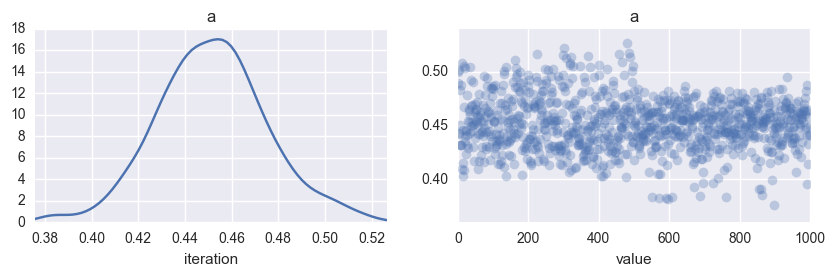

In [9]:
# plot estimates for alpha (intercept)
tools.plot_fit_params(prediction_fit, ['a'])

In [10]:
# Get beta coefficient estimates
beta_estimates = pd.Series(prediction_fit['b'].mean(0), index=probe_ids)
beta_se = pd.Series(prediction_fit['b'].std(0), index=probe_ids)

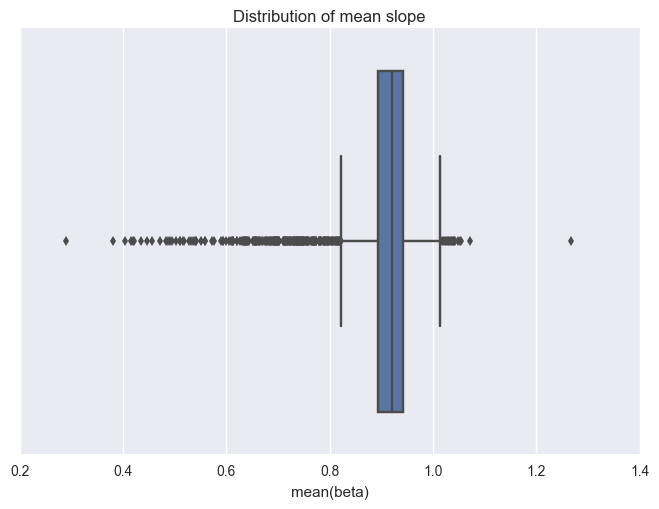

In [11]:
# Plot means distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean slope")
g.set_xlabel("mean(beta)");

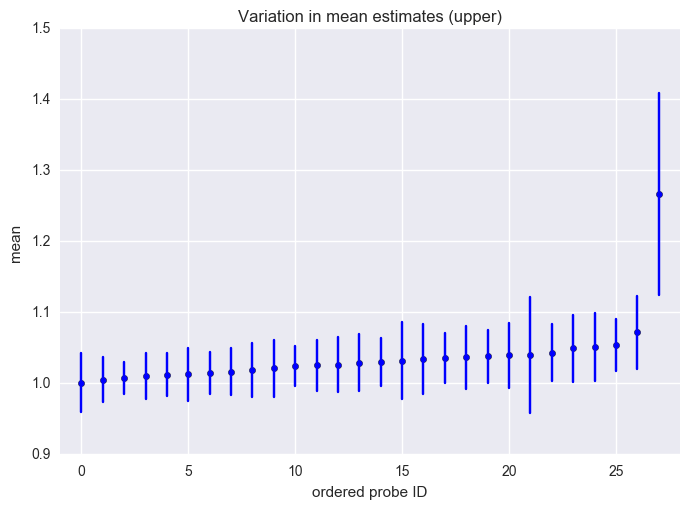

In [12]:
# errors for slope outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 1)

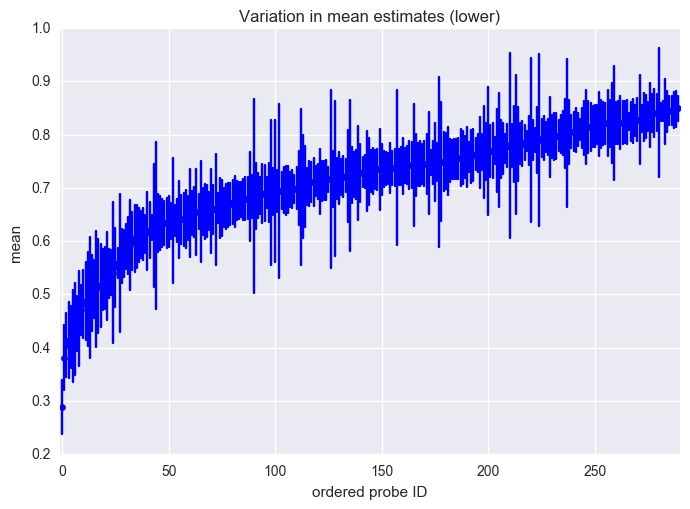

In [13]:
# errors for slope outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.85, upper=False)

# Recovering predictions

In [14]:
# Get beta coefficient estimates
y_pred_estimates = pd.Series(prediction_fit['y_pred'].mean(0))
y_pred_se = pd.Series(prediction_fit['y_pred'].std(0))

In [15]:
test_data = test_data.reset_index(drop=True)
test_data['y_pred_mean'] = y_pred_estimates
test_data['y_pred_se'] = y_pred_se
test_data.sort_values('locus_tag', inplace=True)

In [16]:
test_data.head()

,dh10b_match,input,locus_tag,log_input,log_output,match,output,probe,replicate,sakai_match,treatment,probe_index,locus_index,y_pred_mean,y_pred_se
153,1.0,1936.551867,ECDH10B_RS00060,7.568664,7.251387,lcl|NC_010473.1_cds_WP_001102367.1_12,1410.059000,A_07_P010755,3,0,1,1727,8019,7.410671,0.553284
336,1.0,7794.080333,ECDH10B_RS00080,8.961120,9.039234,lcl|NC_010473.1_cds_WP_001300563.1_16,8427.315333,A_07_P014253,3,0,1,1429,5182,8.989923,0.525710
697,1.0,27161.986667,ECDH10B_RS00080,10.209574,9.989665,lcl|NC_010473.1_cds_WP_001300563.1_16,21799.996667,A_07_P014253,3,0,0,1429,5182,10.119865,0.525732
1475,1.0,316.485567,ECDH10B_RS00110,5.757278,5.599909,lcl|NC_010473.1_cds_WP_001274021.1_23,270.401733,A_07_P010803,3,1,1,1246,7943,5.531196,0.533018
867,1.0,18927.116667,ECDH10B_RS00145,9.848351,9.607503,lcl|NC_010473.1_cds_WP_001239142.1_30,14875.976667,A_07_P010837,3,1,0,1243,7925,9.476857,0.531038


(0, 1728)

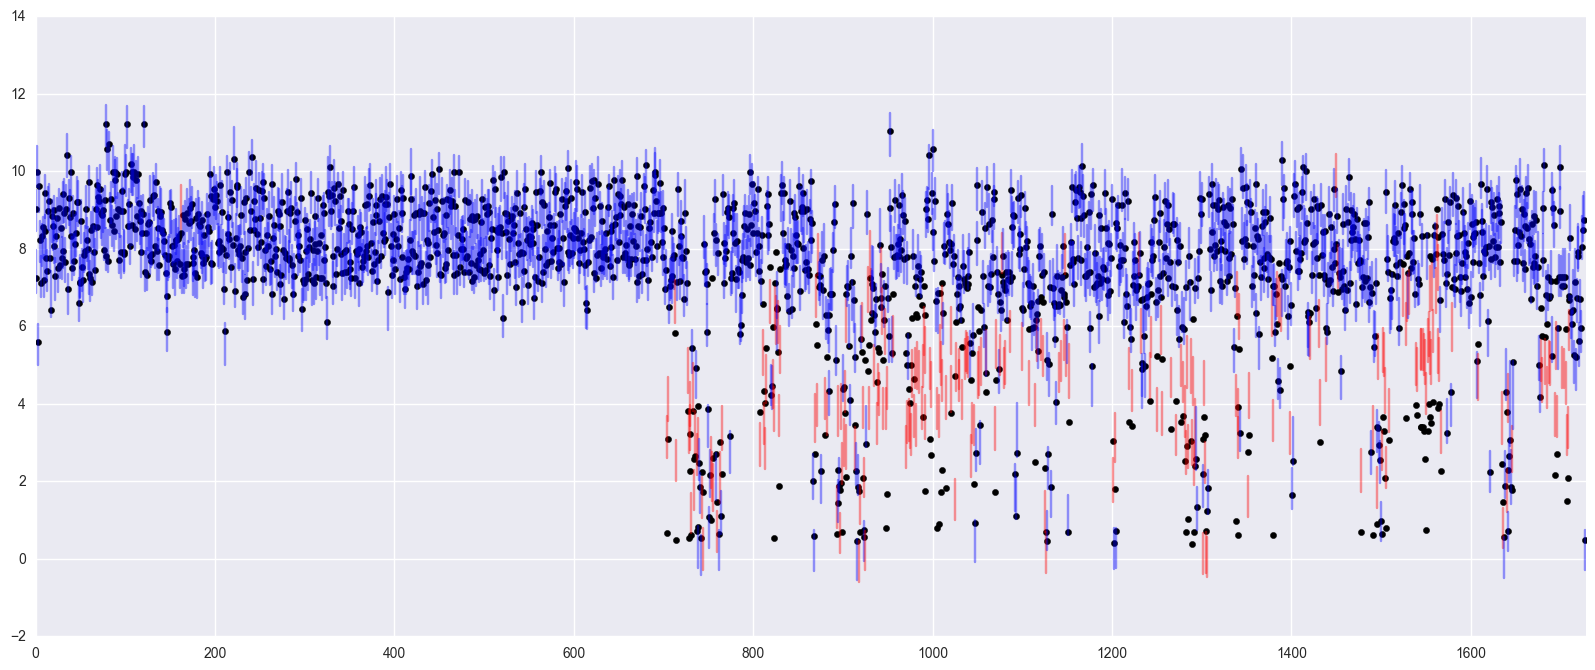

In [22]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
plt.scatter(range(len(test_data)), test_data['log_output'], alpha=1, color='k')
for idx, pmn, pse, mlo in zip(range(len(test_data)),
                              test_data['y_pred_mean'],
                              test_data['y_pred_se'],
                              test_data['log_output']):
    if pse > abs(pmn-mlo):
        color = 'b-'
    else:
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    plt.plot([idx, idx], [pmn - pse, pmn + pse], color, alpha=0.4)
plt.xlim(0, len(test_data))
#plt.xlim(800, 1000)

In [18]:
beta_means = pd.DataFrame(beta_estimates)
beta_means.reset_index(inplace=True)
beta_means.columns = ['probe', 'beta']
beta_means.head()

,probe,beta
0,A_07_P052986,0.455193
1,A_07_P045401,0.435322
2,A_07_P052976,0.630235
3,A_07_P045384,0.415224
4,A_07_P045369,0.999735


In [19]:
out = pd.merge(test_data, beta_means, 'inner', ['probe'])

(0, 1728)

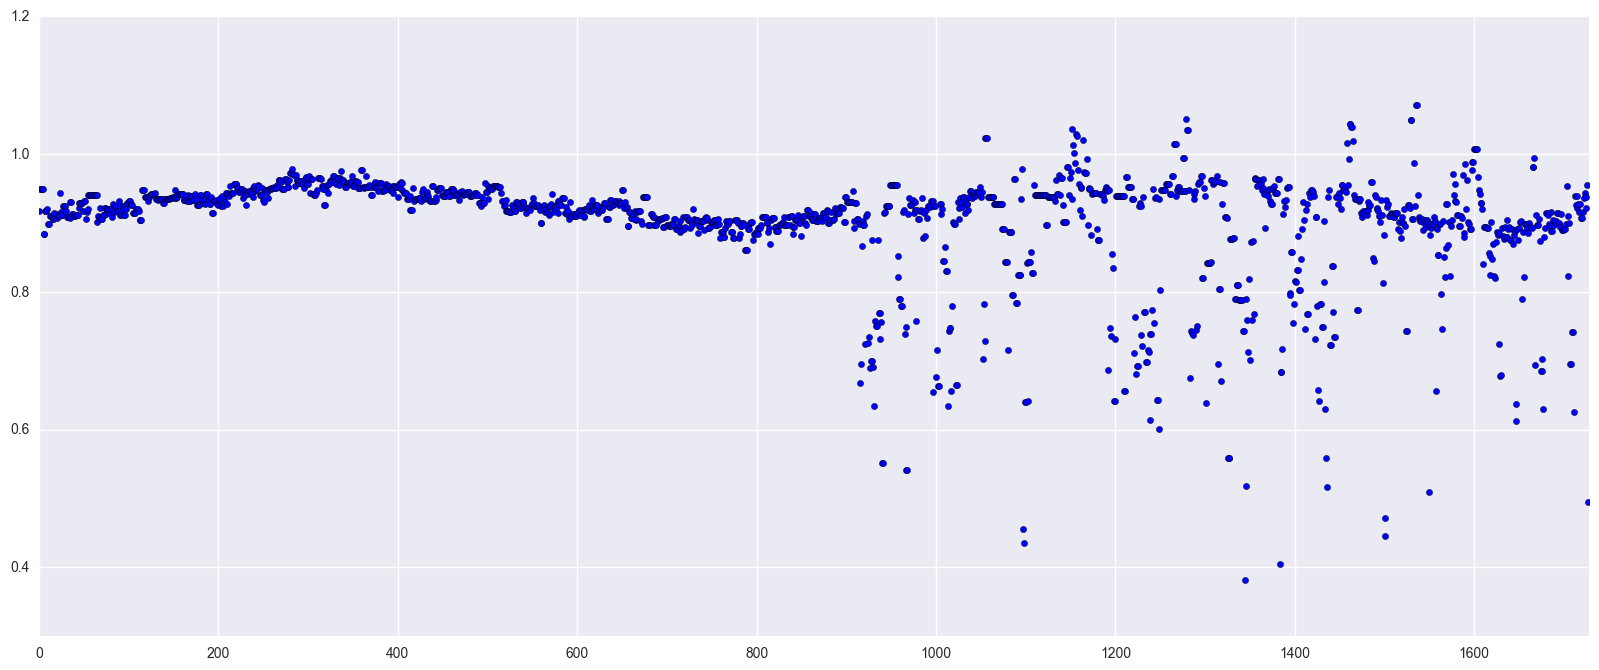

In [20]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
#plt.scatter(range(len(test_data)), test_data['beta'], alpha=1, color='k')
plt.scatter(range(len(test_data)), out['beta'])
for idx, pmn, pse, mlo in zip(range(len(out)),
                              out['y_pred_mean'],
                              out['y_pred_se'],
                              out['log_output']):
    if pse > abs(pmn-mlo):
        color = 'b-'
    else:
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    #plt.plot([idx, out['beta']])
plt.xlim(0, len(out))
#plt.xlim(800, 1000)